# Überbauungsziffer

1. query over a wfs from geodienste.ch houses and properties as polygons
2. calc for all properties the area of houses on it.
3. Überbauungsziffer = area_of_the_house/area_of_the_property.

In [1]:
import json
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape
from shapely.ops import unary_union

In [2]:
plt.rcParams["figure.figsize"] = (16,9/2)
plt.rcParams['figure.dpi'] = 300

### 1. Define area of interest

In [3]:
center = (2683268, 1248001)
radius = 5000

In [4]:
boun_box = (center[0] - radius / 2, center[1] - radius / 2,
            center[0] + radius / 2, center[1] + radius / 2)
geodienste_av = 'https://geodienste.ch/db/av_0'
wfs_av = WebFeatureService(url=geodienste_av,  version='2.0.0', timeout=400)
liegenschaften = gpd.read_file(wfs_av.getfeature(typename='ms:RESF', bbox=boun_box))
bodenbedeckung = gpd.read_file(wfs_av.getfeature(typename='ms:LCSFC', bbox=boun_box))

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
gebäude = bodenbedeckung[bodenbedeckung.Art=='Gebaeude']

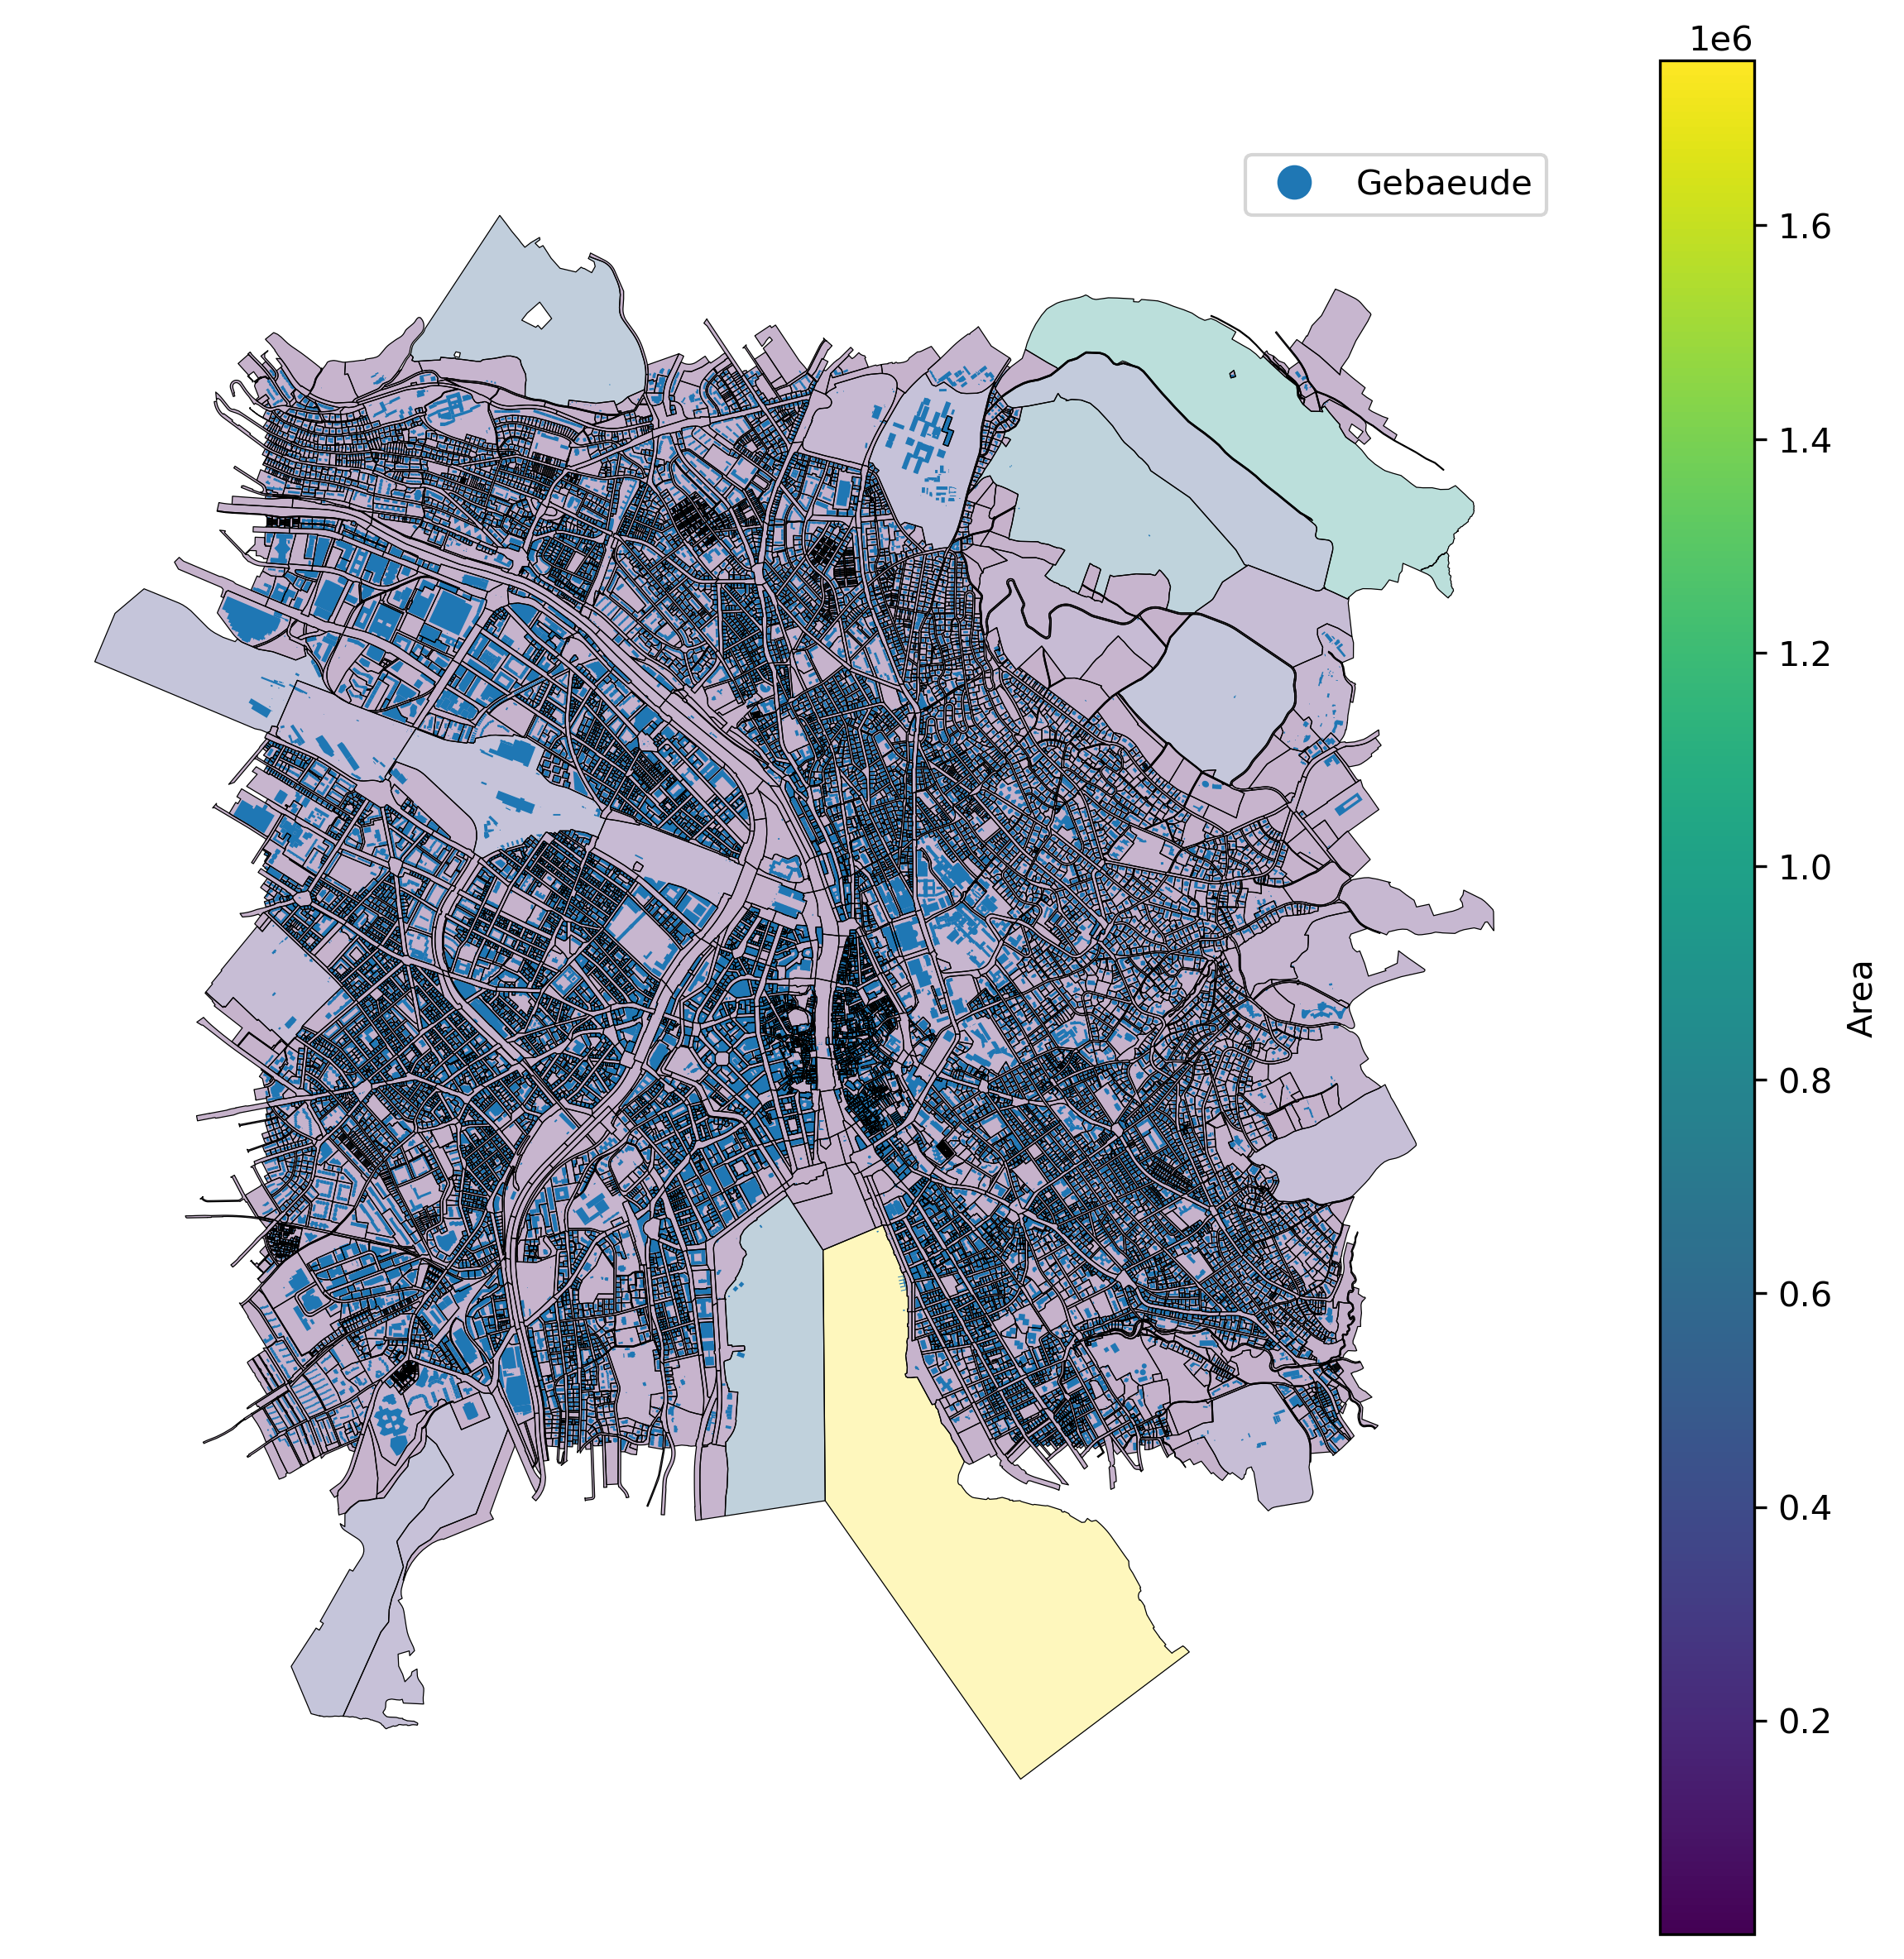

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
liegenschaften.plot(ax=ax, column='Flaeche', alpha=0.3, legend=True, legend_kwds={'label':"Area",'orientation':"vertical"})
liegenschaften.boundary.plot(ax=ax, color='k', linewidth=0.3)
gebäude.plot(ax=ax, column='Art', legend=True)
plt.axis('off');

### 2. Calculate the area occupied by a house for each property.

In [7]:
%%time
gebäude_list = []
for geb in gebäude.iterfeatures():
    gebäude_list.append(shape(geb['geometry']))
gebäude_union = unary_union(gebäude_list)

CPU times: user 52.7 s, sys: 25.4 ms, total: 52.8 s
Wall time: 52.8 s


In [8]:
def calc_overlap_area(geom1, geom2):
    """geom1 & geom2: shapely.geometry.polygon.Polygon
    Output: float"""
    overlap = geom1.intersection(geom2)
    return overlap.area

In [9]:
%%time
liegenschaften['Gebaedeflaeche'] = liegenschaften.geometry.apply(lambda x: calc_overlap_area(x,gebäude_union))
liegenschaften['ueberbauungsziffer'] = liegenschaften.Gebaedeflaeche / liegenschaften.area

CPU times: user 33min 35s, sys: 43.2 ms, total: 33min 35s
Wall time: 33min 35s


In [10]:
liegenschaften.head()

gml_id  BFSNr       NBIdent  Nummer     EGRIS_EGRID  \
0  RESF.419473205    261  ZH0200000261  FL3191  CH467899911273   
1  RESF.419473207    261  ZH0200000261   OB297  CH999970919151   
2  RESF.419473209    261  ZH0200000261  FL3355  CH607891939982   
3  RESF.419473211    261  ZH0200000261  AU6499  CH619127997835   
4  RESF.419473212    261  ZH0200000261  AU2935  CH350199789193   

  Vollstaendigkeit  Flaeche Kanton  \
0     Vollstaendig      950     ZH   
1     Vollstaendig      179     ZH   
2     Vollstaendig     2115     ZH   
3     Vollstaendig      713     ZH   
4     Vollstaendig      421     ZH   

                                            geometry  Gebaedeflaeche  \
0  POLYGON ((2684280.192 1248032.204, 2684280.854...      312.335405   
1  POLYGON ((2683762.558 1248123.506, 2683762.684...      135.344221   
2  POLYGON ((2684006.629 1248026.818, 2684006.297...        0.000000   
3  POLYGON ((2682096.089 1248034.423, 2682112.042...      562.503342   
4  POLYGON ((2681082.937 1248030.386, 2681089.923...      181.414786   

   ueberbauungsziffer  
0            0.328695  
1            0.757100  
2            0.000000  
3            0.788880  
4            0.430578

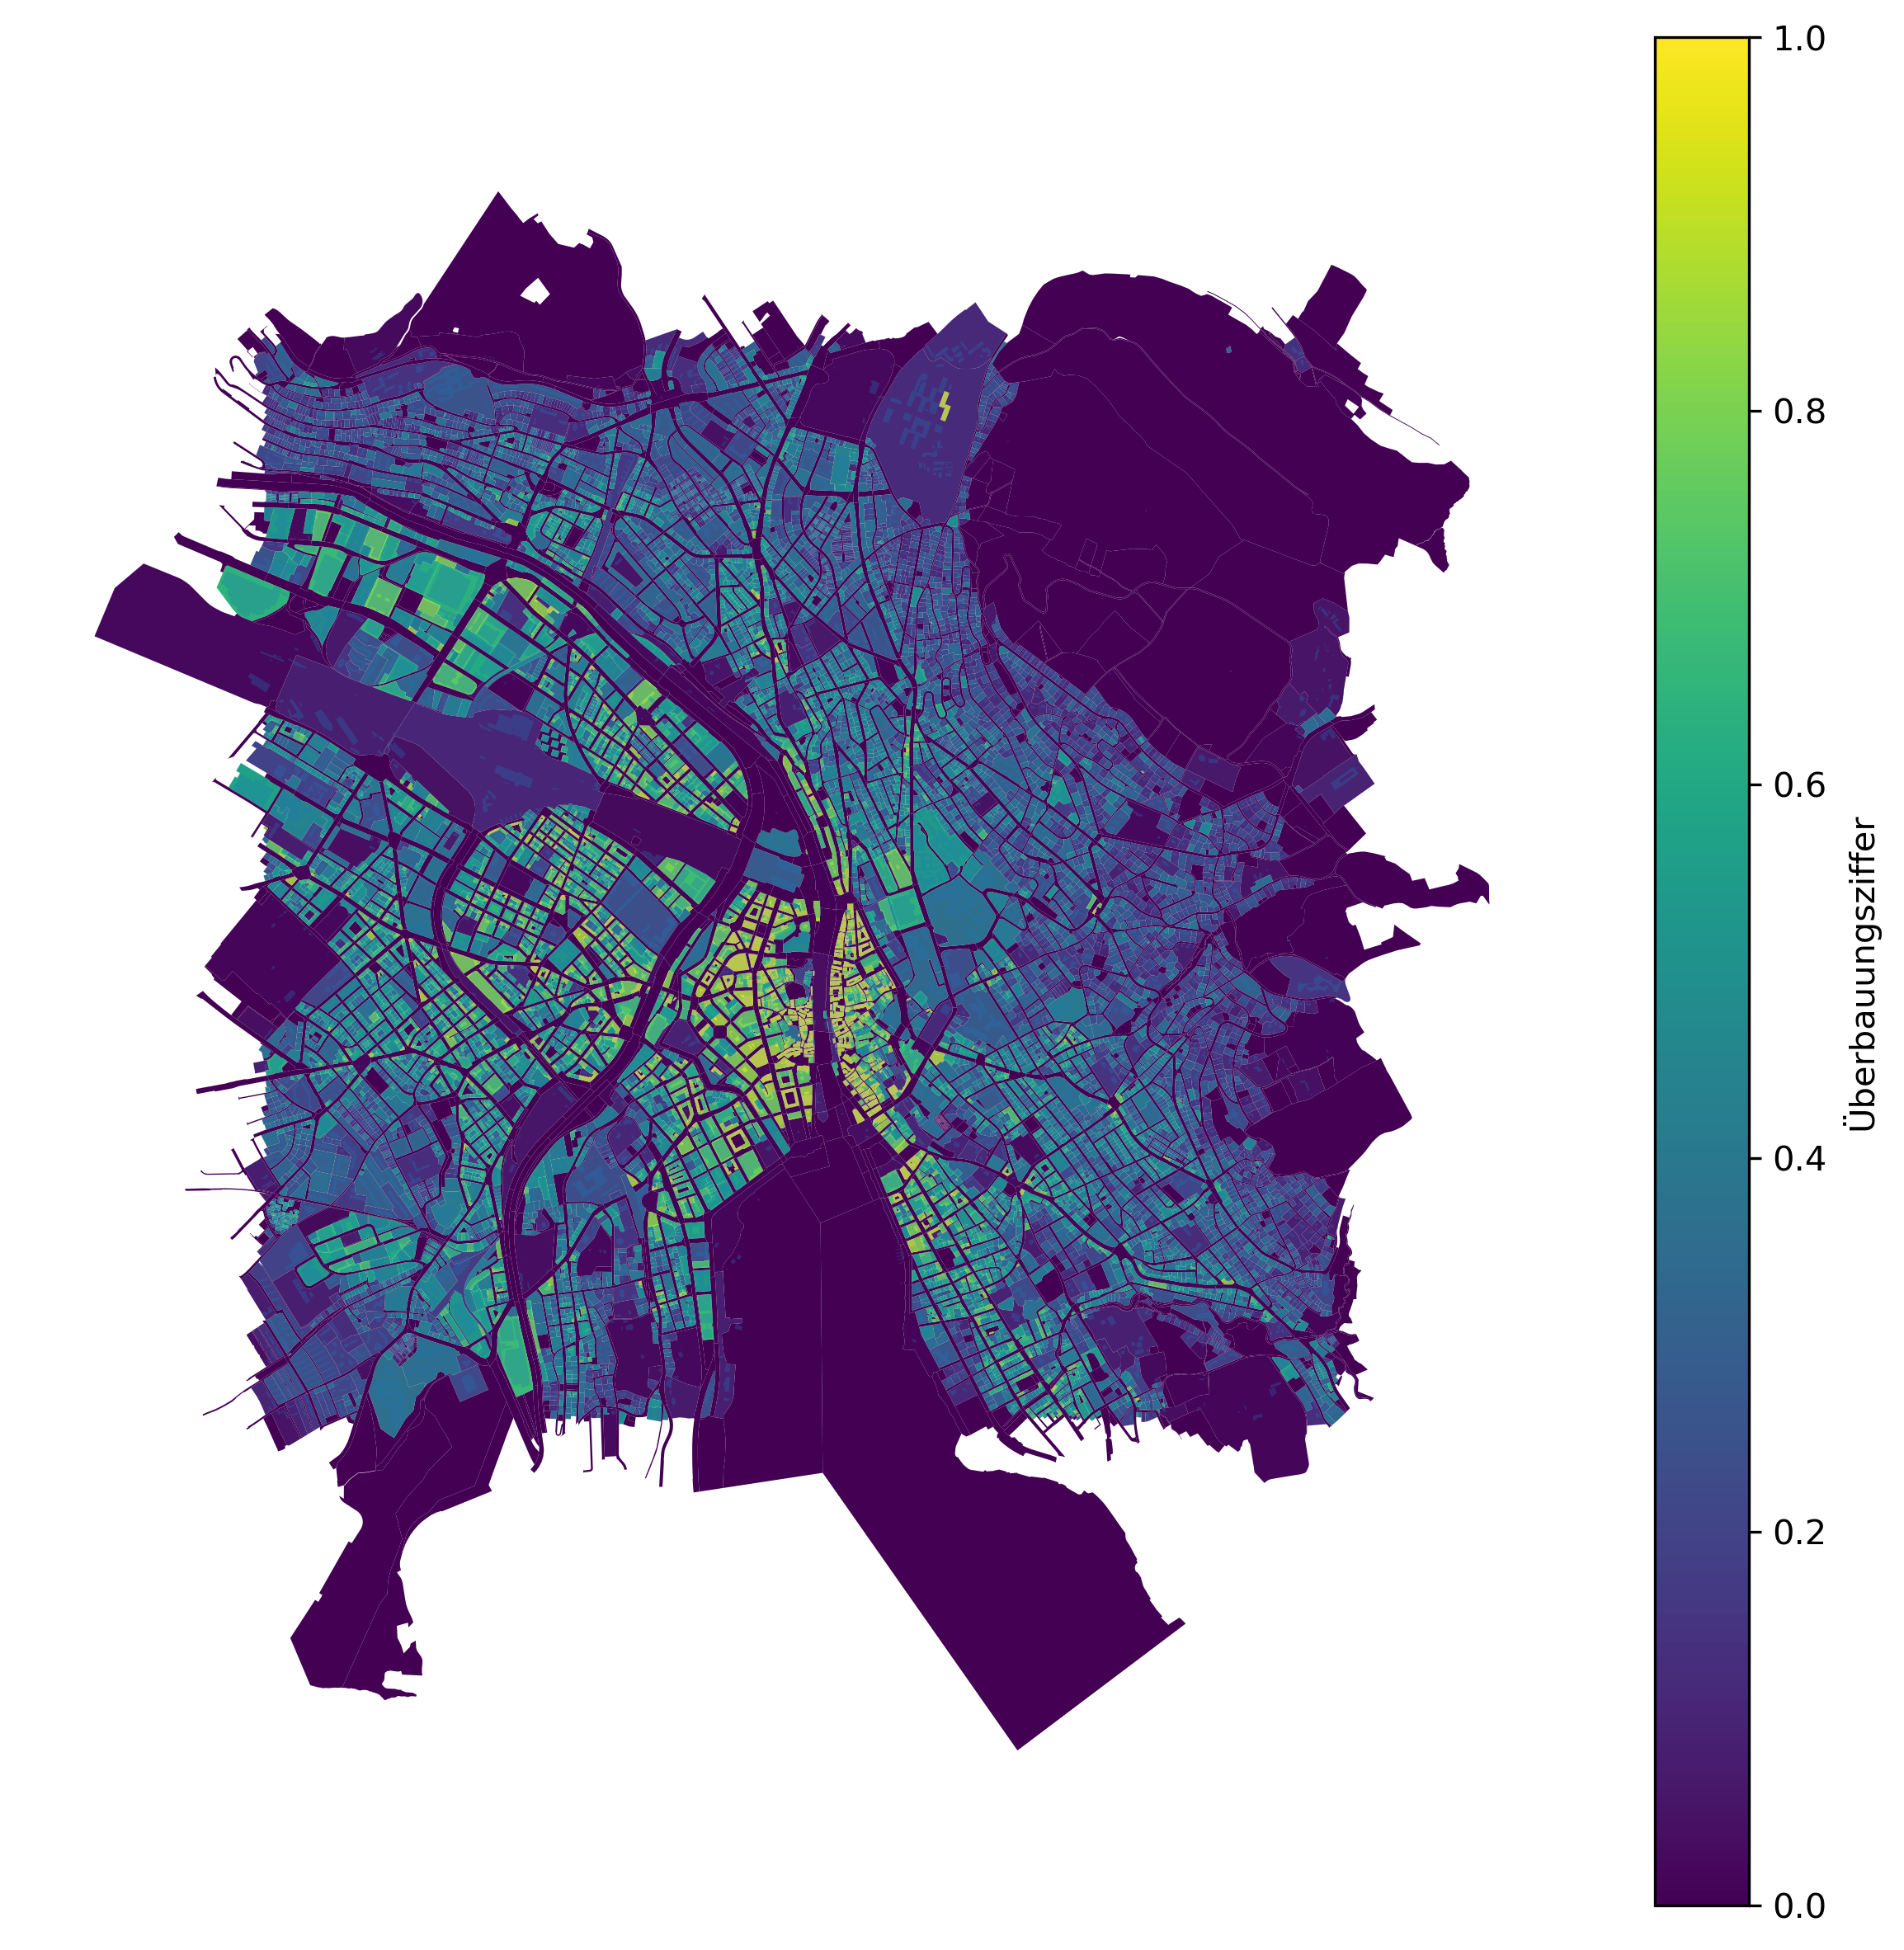

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
liegenschaften.plot(ax=ax, column='ueberbauungsziffer', legend=True, legend_kwds={'label':"Überbauungsziffer",'orientation':"vertical"})
gebäude.plot(ax=ax, column='Art', legend=False, alpha = 0.3)
plt.axis('off');